### Training a Random Forest Algorithm Model

In [ ]:
# Data Processing
import pandas as pd
import numpy as np

#Model Algorithms
from sklearn.ensemble import RandomForestClassifier

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.metrics import classification_report, accuracy_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


#SMOTE for rare classes in Offense Category
from imblearn.over_sampling import SMOTE

#Visualization
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt


df = pd.read_csv("./Datasets/CT-Combined/combined_data.csv")

In [2]:
# Drop rare offense categories (< 50 rows)
classes = df['offense_category_name'].value_counts()
common_classes = classes[classes >= 100].index
df = df[df['offense_category_name'].isin(common_classes)]

##### One Hot Encoder for X

In [3]:
# Here, what I am doing is that I'm turning all features that aren't numerical into numerical format
# One hot encoder is best for nominal data where there's no ranks
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output= False).set_output(transform='pandas')
ohetransform = ohe.fit_transform(df[['city', 'location_area']])

# X is the input features (what the model learns from)
numerical_features = df[['year', 'hour']]
X = pd.concat([numerical_features, ohetransform], axis = 1)

##### Label Encoder for y

In [4]:
le = LabelEncoder()
y = le.fit_transform(df["offense_category_name"])

##### Train Test Split for both X and y

In [5]:
#random_state is keeping the the result exact same everytime you run it, likes like a random_seed
#test_size is to give the model 20% of the dataset to test on
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, test_size=0.2, stratify=y)

In [6]:
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [7]:
print(X.shape, y.shape)

(366933, 143) (366933,)


##### Train the model on the data

In [8]:
model = RandomForestClassifier(
    n_estimators=100,       
    min_samples_split=16,     
    max_depth=32,  
    random_state=42,
    class_weight='balanced'
)

In [9]:
#Random Forest (46.51%):
model.fit(X_train, y_train) 

RandomForestClassifier(class_weight='balanced', max_depth=32,
                       min_samples_split=16, random_state=42)

In [10]:
y_prob = model.predict_proba(X_test)

# Calculate log loss
loss = log_loss(y_test, y_prob)
print(f"Log Loss: {loss:.4f}")

Log Loss: 2.2692


In [11]:
# Make predictions
y_pred = model.predict(X_test)

In [12]:
# Evaluate model
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 26.20%

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.13      0.01        71
           1       0.01      0.11      0.01       103
           2       0.47      0.20      0.28     13999
           3       0.16      0.30      0.21      2721
           4       0.17      0.49      0.25       894
           5       0.32      0.11      0.16     10194
           6       0.32      0.41      0.36      3749
           7       0.01      0.27      0.02       104
           8       0.03      0.36      0.06       135
           9       0.56      0.42      0.48      7036
          10       0.01      0.16      0.01        85
          11       0.01      0.26      0.03       171
          12       0.79      0.29      0.43     24295
          13       0.20      0.24      0.22      4746
          14       0.06      0.45      0.10       180
          15       0.02      0.54      0.03        24
          16       0.07      0.18      0

In [13]:
# Feature importance analysis
features_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(features_importance.head(10))


Top 10 Most Important Features:
                                              feature  importance
1                                                hour    0.344925
0                                                year    0.092387
111                          location_area_Cyberspace    0.047195
121  location_area_Highway/Road/Alley/Street/Sidewalk    0.039829
103               location_area_Bank/Savings and Loan    0.037684
132                      location_area_Residence/Home    0.032147
122                    location_area_Hotel/Motel/Etc.    0.022587
36                                      city_Hartford    0.020576
49                                     city_New Haven    0.019863
130             location_area_Parking/Drop Lot/Garage    0.015182


In [14]:
print("\nClass Labels:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")


Class Labels:
0: Animal Cruelty
1: Arson
2: Assault Offenses
3: Burglary/Breaking & Entering
4: Counterfeiting/Forgery
5: Destruction/Damage/Vandalism of Property
6: Drug/Narcotic Offenses
7: Embezzlement
8: Extortion/Blackmail
9: Fraud Offenses
10: Homicide Offenses
11: Kidnapping/Abduction
12: Larceny/Theft Offenses
13: Motor Vehicle Theft
14: Pornography/Obscene Material
15: Prostitution Offenses
16: Robbery
17: Sex Offenses
18: Sex Offenses, Non-forcible
19: Stolen Property Offenses
20: Weapon Law Violations


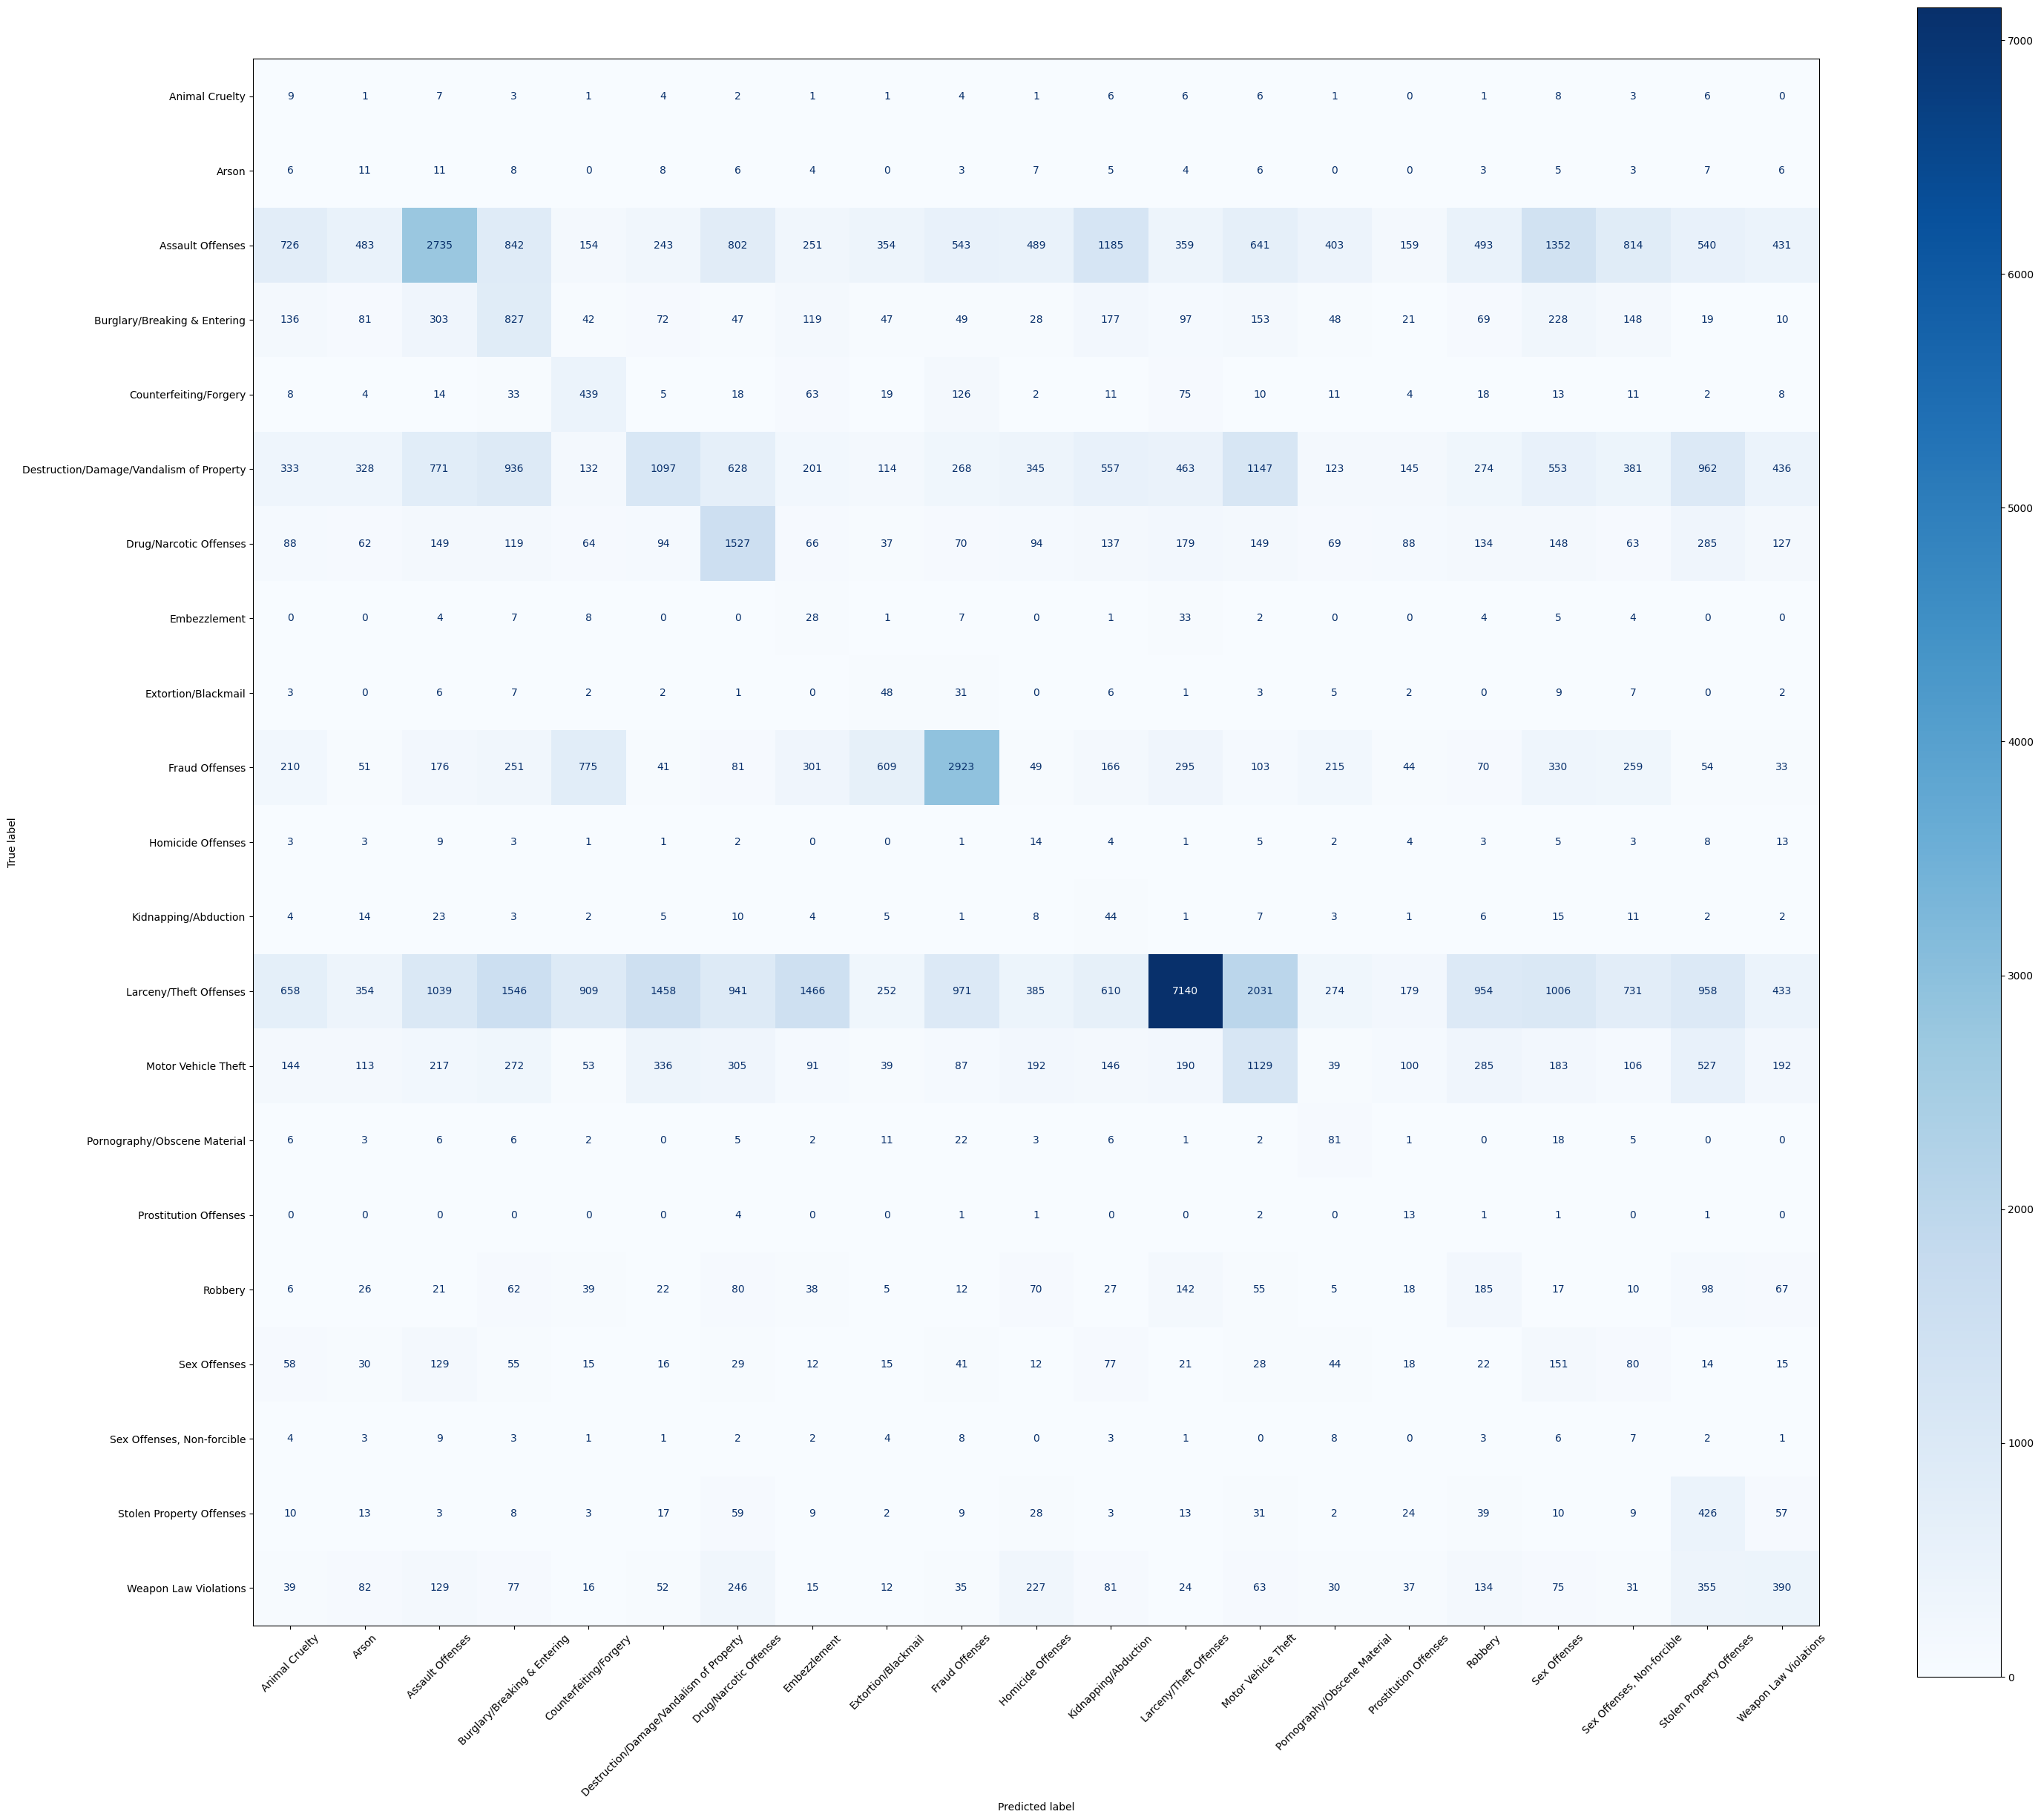

In [18]:
# Compute the matrix
cm = confusion_matrix(y_test, y_pred)

# Plot with larger figure
fig, ax = plt.subplots(figsize=(30, 25))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)

plt.tight_layout()
plt.show()

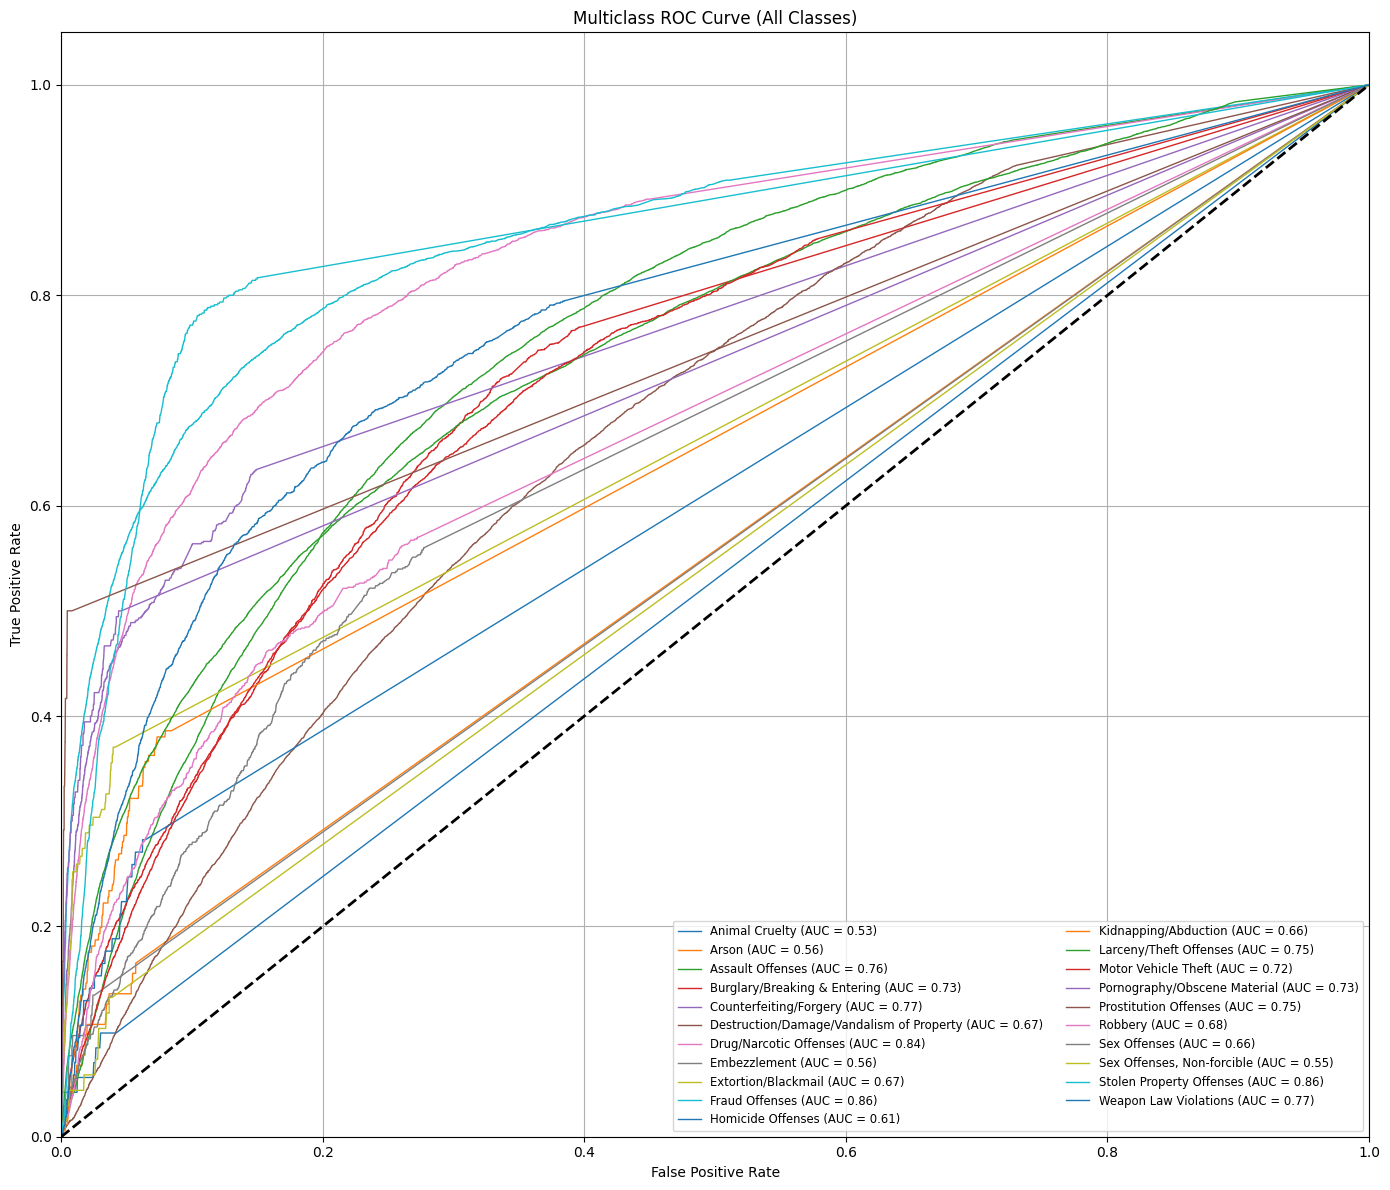

In [ ]:
# Binarize the target
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Train/test split
X_train, X_test, y_train_bin, y_test_bin = train_test_split(
    X, y_bin, test_size=0.2, random_state=42, stratify=y
)

# One-vs-Rest classifier with Random Forest
clf = OneVsRestClassifier(RandomForestClassifier(random_state=42))
clf.fit(X_train, y_train_bin)
y_score = clf.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(14, 12))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=1, label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (All Classes)')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
list(df.columns)

['year',
 'month',
 'day',
 'hour',
 'date',
 'dayofweek',
 'city',
 'population',
 'offense_category_name',
 'location_area',
 'crime_rate_per_1000_people']